Non linear Method

## Communications:

In [96]:
data <- read.csv(file.path("..", "data", "training_data.csv"))
data<-data[,-which(names(data) %in% c("SWEETORSOUR"))] #to remove the SWEETORSOUR response variable
data$Intensity<-as.numeric(as.factor(data$Intensity)) #more efficient, this way we only have one column with 2=high, 1=low
var<-which(apply(data, 2, var) == 0)
data<-data[ ,-var] #remove all columns with variance=0 (900 columns) easier to remove, can use them on test data 
ncol(data)

[1] 3029

In [84]:
set.seed(199)

#data$Intensity<-as.numeric(as.factor(data$Intensity)) #more efficient, this way we only have one column with 2=high, 1=low
#data<-data[ , which(apply(data, 2, var) != 0)] #remove all columns with variance=0

idx.train <- sample(nrow(data), nrow(data)*2/3)
data.train <- data[idx.train,]
datax.train<-data.train[,-which(names(data.train) %in% c("VALENCE.PLEASANTNESS"))]
datay.train<-data.train$VALENCE.PLEASANTNESS

data.test <- data[-idx.train,]
datax.test<-data.test[,-which(names(data.test) %in% c("VALENCE.PLEASANTNESS"))]
datay.test<-as.matrix(data.test$VALENCE.PLEASANTNESS)
#using more data samples

#verifiy if some new cols now have var 0
train.var<-(apply(datax.train, 2, var) != 0)
test.var<-(apply(datax.test,2,var)!=0)

datax.train<-datax.train[,which(test.var&train.var)] #take the same columns for both sets and only when both have var!=0
datax.test<-datax.test[,which(test.var&train.var)]
ncol(data.test)

datax.train<-as.matrix(datax.train)
datax.test<-as.matrix(datax.test)



[1] 3029

In [27]:
#scaling data before nn
get.scale <- function(scaled) {
  if ("scaled:center" %in% names(attributes(scaled))) {
      center <- attr(scaled, "scaled:center")
  } else {
      center <- rep(0, ncol(scaled))
  }
  if ("scaled:scale" %in% names(attributes(scaled))) {
      list(center, attr(scaled, "scaled:scale"))
  } else {
      list(center, rep(1., length(center)))
  }
}
scale.as <- function(x, scaled) {
  s <- get.scale(scaled)
  centered <- sweep(x, 2, s[[1]])
  sweep(centered, 2, s[[2]], FUN = "/")
}
y.unscale <- function(y, scaled) {
    s <- get.scale(scaled)
    y * s[[2]] + s[[1]]
}

#scaled data
#datax.train.sc<-scale(datax.train,center=T,scale=T)
#datay.train.sc<-scale(datay.train,center=T,scale=T)
#datax.test.sc<-scale.as(datax.test,datax.train.sc)
#datay.test.sc<-scale.as(datay.test,datay.train.sc)


________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_64 (Dense)                    (None, 64)                      189632      
________________________________________________________________________________
dense_65 (Dense)                    (None, 64)                      4160        
________________________________________________________________________________
dropout_32 (Dropout)                (None, 64)                      0           
________________________________________________________________________________
dense_66 (Dense)                    (None, 32)                      2080        
________________________________________________________________________________
dropout_33 (Dropout)                (None, 32)                      0           
________________________________________________________________________________
dense_67 (Dense)            

35.15046
32.72109
31.46903
27.55677
33.64154
36.05753
30.56863
34.37249
31.96995
33.98878
31.64812


`geom_smooth()` using formula 'y ~ x'


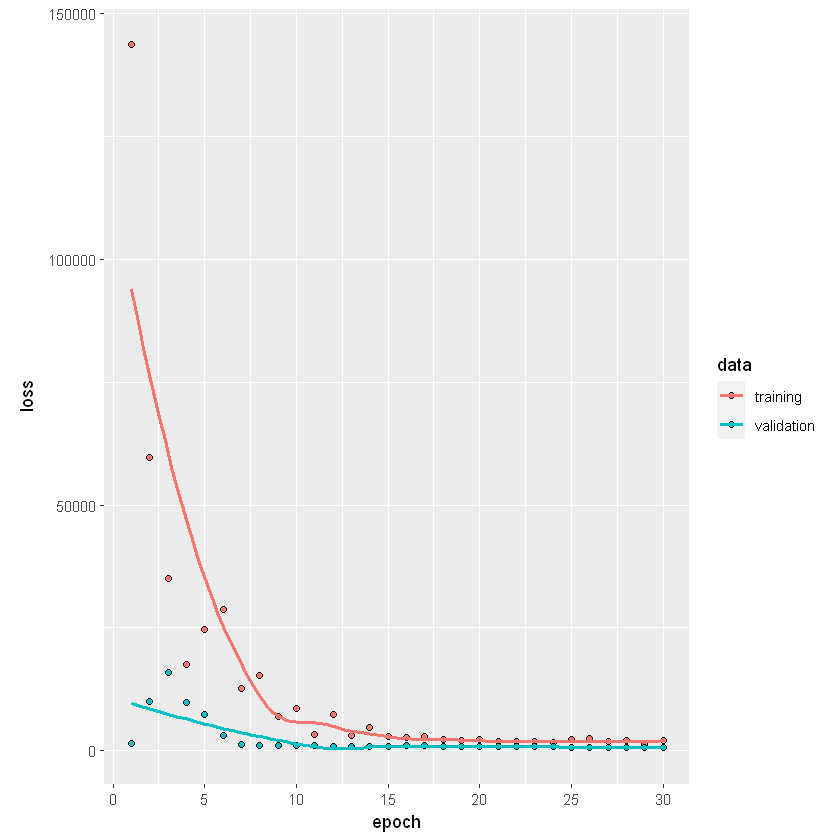

In [85]:


library(keras)
use_condaenv("r-tensorflow")
set.seed(24)

#baseline model
model <- keras_model_sequential() %>% 
   layer_dense(units=64, activation="relu", input_shape=ncol(datax.train)) %>% 
   layer_dense(units=64, activation="relu", kernel_regularizer="l1") %>% 
   #layer_dense(units=32, activation="relu",kernel_regularizer="l1")%>%
   layer_dropout(rate=0.6)%>%
   layer_dense(units=32, activation = "relu") %>% 
   layer_dropout(rate=0.3) %>%                              #dropout layers prevent overfitting to the model
   layer_dense(units=1, activation="linear")


model %>% compile(
   loss = "mse",
   optimizer =  "adam", #this tunes the learning rate
 )

model %>% summary()
history<-model %>% fit(datax.train, 
                       datay.train,
                       epochs=30, #try to keep the training over the validation
                       callback=callback_early_stopping(monitor = "val_loss", patience = 10),
                       verbose = 0,
                       batch_size =100,      #reducing batch_size reduces the RMSE (but increases computation time)
                       validation_split = 0.2)
scores = model %>% evaluate(datax.train, datay.train, verbose = 0)

print(scores)

ypred <- model %>% predict(datax.train)
ypred.test<- model %>% predict(datax.test)

#RMSE
cat("Training RMSE:", sqrt(mean(ypred-datay.train)^2))
cat(" Test RMSE:", sqrt(mean(ypred.test-datay.test)^2))

#ypred.test.unscale<-y.unscale(ypred,datay.train.sc)
# loss=351, Training RMSE=18, Test RMSE=22
ypred.test
plot(history) #the loss doesn't decrease after epoch=20

In [103]:
#create the model based on the whole data
set.seed(24)
datax<-as.matrix(data[,-which(names(data) %in% c("VALENCE.PLEASANTNESS"))])
ncol(datax)
datay<-data$VALENCE.PLEASANTNESS
#baseline model
model_tot <- keras_model_sequential() %>% 
   layer_dense(units=64, activation="relu", input_shape=ncol(datax)) %>% 
   layer_dense(units=64, activation="relu", kernel_regularizer="l1") %>% 
   #layer_dense(units=32, activation="relu",kernel_regularizer="l1")%>%
   layer_dropout(rate=0.6)%>%
   layer_dense(units=32, activation = "relu") %>% 
   layer_dropout(rate=0.3) %>%                              #dropout layers prevent overfitting to the model
   layer_dense(units=1, activation="linear")


model_tot %>% compile(
   loss = "mse",
   optimizer =  "adam", 
 )

model_tot %>% summary()
history<-model_tot %>% fit(datax, 
                       datay,
                       epochs=30, #try to keep the training over the validation
                       callback=callback_early_stopping(monitor = "val_loss", patience = 10),
                       verbose = 0,
                       batch_size =100,      #reducing batch_size reduces the RMSE (but increases computation time)
                       validation_split = 0.2)
scores = model_tot %>% evaluate(datax, datay, verbose = 0)

ypred <- model_tot %>% predict(datax)
cat("  RMSE:", sqrt(mean(ypred-datay)^2))
print(scores)


[1] 3028

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_96 (Dense)                    (None, 64)                      193856      
________________________________________________________________________________
dense_97 (Dense)                    (None, 64)                      4160        
________________________________________________________________________________
dropout_48 (Dropout)                (None, 64)                      0           
________________________________________________________________________________
dense_98 (Dense)                    (None, 32)                      2080        
________________________________________________________________________________
dropout_49 (Dropout)                (None, 32)                      0           
________________________________________________________________________________
dense_99 (Dense)            

In [105]:
#Submission neuron network

data_test <- read.csv(file.path("..", "data", "test_data.csv"))
data_test <- data_test[,-1]

data_test$Intensity<-as.numeric(as.factor(data_test$Intensity)) 
data_test <-data_test[ ,-var]#remove the same predictors   
data_test_matrix <- as.matrix(data_test)


pred_test <- model_tot %>% predict(data_test_matrix)

#pred_test<-y.unscale(pred_test,data_test.sc)

data_sub <- read.csv(file.path("..", "data", "sampleSubmission.csv"))
data_sub <- data_sub[-69,]
data_sub$VALENCE.PLEASANTNESS <- pred_test
data_sub
write.csv(data_sub,file="Sub2.csv", row.names = FALSE)

Id,VALENCE.PLEASANTNESS
1,17.30276
2,36.55402
3,23.73685
4,17.81829
5,23.44365
6,21.21538
7,24.29984
8,14.83002
9,18.68944
10,12.94889


$loss
[1] 537.2822

$acc
[1] 0.002118644

Training RMSE: 23.17935Test RMSE: 23.34588

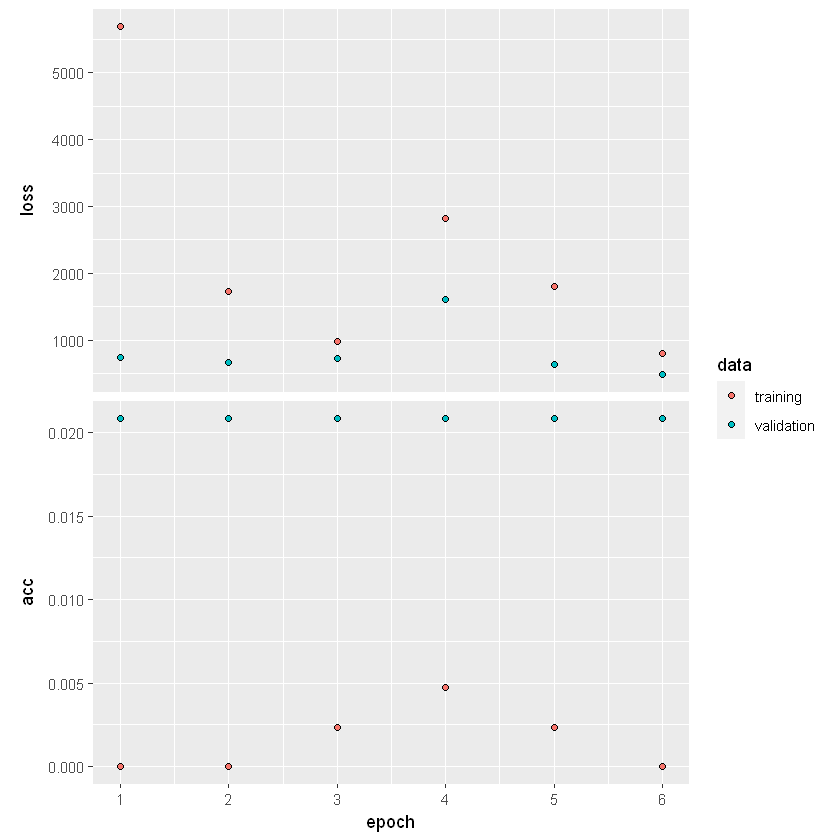

In [37]:
#with convolutional layers (inspired from https://www.datatechnotes.com/2020/01/how-to-fit-regression-data-with-cnn.html)
conv.nn <- keras_model_sequential()
datax.train = array(datax.train, dim = c(nrow(datax.train), ncol(datax.train), 1))
datax.test = array(datax.test,dim = c(nrow(datax.test), ncol(datax.test), 1))
#xtest = array(xtest, dim = c(nrow(xtest), 13, 1))
conv.nn %>%
   layer_conv_1d(filters = 64, kernel_size = 2, input_shape = c(ncol(datax.train),1), activation = "relu") %>%
   layer_flatten() %>%
   layer_dense(units=64, activation="relu") %>% 
   layer_dense(units=32, activation = "relu") %>% 
   layer_dense(units=1, activation="linear")

conv.nn %>% compile(
  loss = 'mse',
  optimizer = 'adam',
  metrics = c('accuracy')
)
history <- conv.nn %>% fit(
  datax.train, datay.train,
  epochs = 6, batch_size =8,      #reducing batch_size reduces the RMSE (but increases computation time)
  validation_split = 0.1, verbose=0
)
plot(history)

scores = conv.nn %>% evaluate(datax.train, datay.train, verbose = 0)
print(scores)

ypred = conv.nn %>% predict(datax.train)
ypred.test= conv.nn %>% predict(datax.test)
cat("Training RMSE:", sqrt(mean((ypred-datay.train)^2)))
cat("Test RMSE:", sqrt(mean((ypred.test-datay.test)^2)))
#training RMSE =21, test RMSE=23 worse than without convolutional  layer, stable after epochs =6


## Trees

peut etre faire cross validation sur la methode qui donne le moins de RMSE 

In [1]:
data <- read.csv(file.path("..", "data", "training_data.csv"))
data<-data[,-which(names(data) %in% c("SWEETORSOUR"))]
data$Intensity<-as.numeric(as.factor(data$Intensity)) 
data<-data[ ,( which(apply(data, 2, var) != 0))]

In [2]:
library(tree)
library(randomForest)
library(xgboost)

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.


In [4]:
set.seed(199)
idx.train <- sample(nrow(data), nrow(data)/2)
data.train <- data[idx.train,]
data.test <- data[-idx.train,]

data.train.x <- data.train[,-which(names(data.train) %in% c("VALENCE.PLEASANTNESS"))]
#data.train.x.matrix <- as.matrix((model.matrix(~.-1, data.train.x)))
data.train.y <- data.train$VALENCE.PLEASANTNESS

data.test.x <- data.test[,-which(names(data.test) %in% c("VALENCE.PLEASANTNESS"))]
#data.test.x.matrix <- as.matrix((model.matrix(~.-1, data.test.x)))
data.test.y <- data.test$VALENCE.PLEASANTNESS

In [6]:
#Tree ok
tree.data.train <- tree(VALENCE.PLEASANTNESS ~ ., data = data.train)
summary(tree.data.train)
#plot(tree.data)
#text(tree.data, pretty = 0,cex=0.4)

pred.test <- predict(tree.data.train, newdata = data.test.x)
MSE.test <- mean((pred.test - data.test.y)^2)
RMSE.test <- sqrt(MSE.test)
print(paste0('test MSE :', MSE.test))
print(paste0('test RMSE :', RMSE.test))

pred.train <- predict(tree.data.train,data.train.x)
MSE.train <- mean((pred.train - data.train.y)^2)
RMSE.train <- sqrt(MSE.train)
print(paste0('train MSE :', MSE.train))
print(paste0('train RMSE :', RMSE.train))


Regression tree:
tree(formula = VALENCE.PLEASANTNESS ~ ., data = data.train)
Variables actually used in tree construction:
 [1] "Eig04_EA.ri."           "Mor21v"                 "GNar"                  
 [4] "Mor10e"                 "P_VSA_MR_7"             "B04.C.S."              
 [7] "P_VSA_LogP_2"           "R6s."                   "HATS6p"                
[10] "GATS4m"                 "Mor10s"                 "Mor07p"                
[13] "HATS7s"                 "JGI2"                   "Mor03m"                
[16] "MATS4m"                 "GATS5e"                 "Mor27u"                
[19] "G3u"                    "complexity.from.pubmed" "DLS_cons"              
[22] "RTs"                    "RDF045s"                "G3e"                   
Number of terminal nodes:  25 
Residual mean deviance:  220.8 = 72640 / 329 
Distribution of residuals:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-41.6200  -9.1760   0.0625   0.0000   8.3780  50.9100 

[1] "test MSE :756.039616713886"
[1] "test RMSE :27.4961745832741"
[1] "train MSE :205.210269500844"
[1] "train RMSE :14.325162110805"


In [5]:
#Pruning tree with cv 
#We run 6-fold cross-validation, because our training data has size 354, which is a multiple of 6.

function.train <- function(train) {
    formula <- data$VALENCE.PLEASANTNESS ~ .
    tree(formula, data, subset = train)
}
evaluate <- function(tree, set) {
    sapply(2:10, function(i) mean((data$VALENCE.PLEASANTNESS[set] - predict(prune.tree(tree, best = i), data[set,]))^2)) # We compute the mean squared error for all trees with 2 to 10 leaf nodes.
}
           
data.cv <- function(train) {
    res <- sapply(1:6, function(v) {
                            idx.test <- seq((v-1)*22 + 1, v*22) # fold index
                            this.fold.test <- train[idx.test]   # validation
                            this.fold.train <- train[-idx.test] # training
                            tree <- function.train(this.fold.train)
                            evaluate(tree, this.fold.test)
                        })
    rowMeans(data.frame(res))
}
           
train.and.evaluate <- function() {
    train <- sample(nrow(data), 354) #nrow = 708 et 354 = training set
    tree <- function.train(train)
    list(train = evaluate(tree, train),
         test = evaluate(tree, -train),
         cv = data.cv(train),
         tree = tree)
}
           
set.seed(1)
           
res <- replicate(100, train.and.evaluate()) # we run everything for 100 different training sets

for(i in 1:3) {
    df <- data.frame(res[i,])
    m <- rowMeans(df)
    RMSE <- sqrt(rowMeans((df - m)^2))
    print(paste0('RMSE ',i,' : ', RMSE))
    print(paste0('RMSE min ', i, ' : ', min(RMSE),' with a prune tree size of : ', which.min(RMSE)))
}
#1=train RMSE
#2=test RMSE
#3=CV   

[1] "RMSE 1 : 24.7652395336342" "RMSE 1 : 26.5063409590402"
[3] "RMSE 1 : 24.1196833104704" "RMSE 1 : 23.7097052439343"
[5] "RMSE 1 : 23.8983033534044" "RMSE 1 : 21.4420779034151"
[7] "RMSE 1 : 21.5942531389359" "RMSE 1 : 20.7252735655129"
[9] "RMSE 1 : 19.9233093764502"
[1] "RMSE min 1 : 19.9233093764502 with a prune tree size of : 9"
[1] "RMSE 2 : 28.9083599838031" "RMSE 2 : 30.5027386156728"
[3] "RMSE 2 : 31.0973874203512" "RMSE 2 : 32.7902261841804"
[5] "RMSE 2 : 36.7181416980928" "RMSE 2 : 37.7603531287775"
[7] "RMSE 2 : 38.8099444724328" "RMSE 2 : 40.8147661435035"
[9] "RMSE 2 : 42.9986416308224"
[1] "RMSE min 2 : 28.9083599838031 with a prune tree size of : 1"
[1] "RMSE 3 : 58.6008467600797" "RMSE 3 : 65.0558853544193"
[3] "RMSE 3 : 68.440658096469"  "RMSE 3 : 69.3563603573839"
[5] "RMSE 3 : 73.7460044938495" "RMSE 3 : 76.4623778546147"
[7] "RMSE 3 : 77.6084690806776" "RMSE 3 : 79.2144236268917"
[9] "RMSE 3 : 81.9706245010275"
[1] "RMSE min 3 : 58.6008467600797 with a prune tree

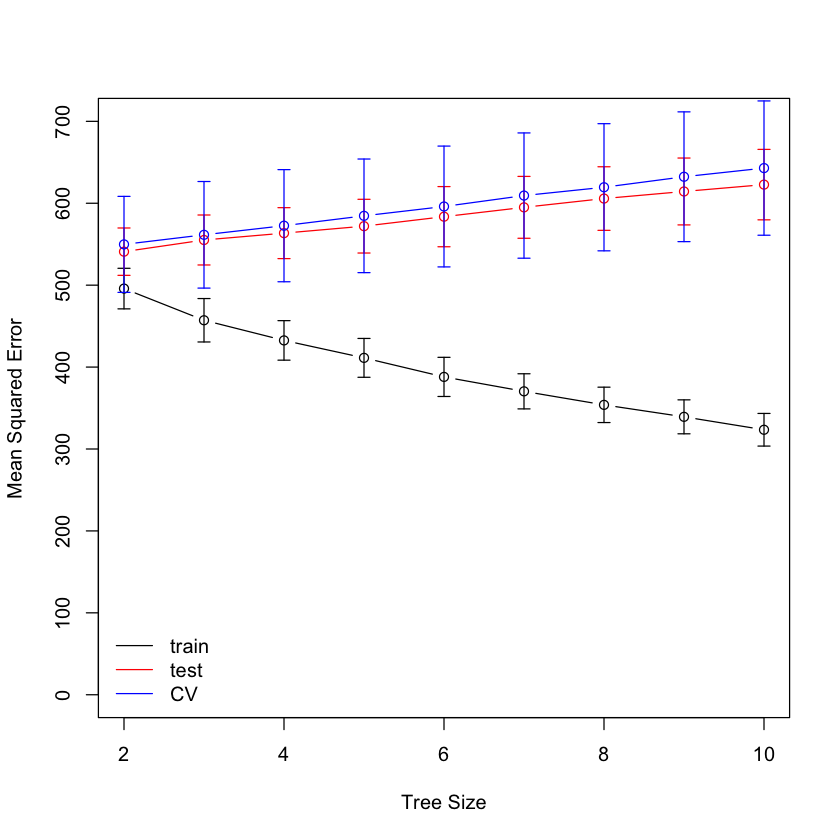

In [6]:
std.plot <- function(data, x = 2:10, ...) {
    df <- data.frame(data)
    m <- rowMeans(df)
    std <- sqrt(rowMeans((df - m)^2))
    points(x, m, type = "b", ...)
    arrows(x, m - std, x, m + std, length=0.05, angle=90, code=3, ...)
}

plot(c(), ylim = c(.1, 700), xlim = c(2, 10), xlab = "Tree Size", ylab = "Mean Squared Error")
std.plot(res[1,])
std.plot(res[2,], col = "red")
std.plot(res[3,], col = "blue")
legend("bottomleft", c("train", "test", "CV"), bty = 'n', col = c("black", "red", "blue"), lty = 1)

In [8]:
#Bagging ok
set.seed(1)
m <- 3028 # in Bagging, we consider all the predictors as split candidates
bag <- randomForest(VALENCE.PLEASANTNESS ~ ., data = data.train, mtry = m) #ntree = 500 par defaut, peut etre essayer avec 1000 une fois ?
pred.bag.test <- predict(bag, newdata = data.test.x)
MSE.test = mean((pred.bag.test - data.test.y)^2)
RMSE.test = sqrt(MSE.test)
print(paste0('test MSE :', MSE.test))
print(paste0('test RMSE :', RMSE.test))
#--> RMSE = 18.4237592975258

pred.bag.train <- predict(bag,data.train.x)
MSE.train = mean((pred.bag.train - data.train.y)^2)
RMSE.train = sqrt(MSE.train)
print(paste0('train MSE :', MSE.train))
print(paste0('train RMSE :', RMSE.train))

[1] "test MSE :517.367327952118"
[1] "test RMSE :22.7457100999753"
[1] "train MSE :103.219968042396"
[1] "train RMSE :10.1597228329515"


[1] "m that give the min test RMSE is :106"
[1] "test RMSE min :22.8933439498098"
[1] "train RMSE min :11.8907143599555"


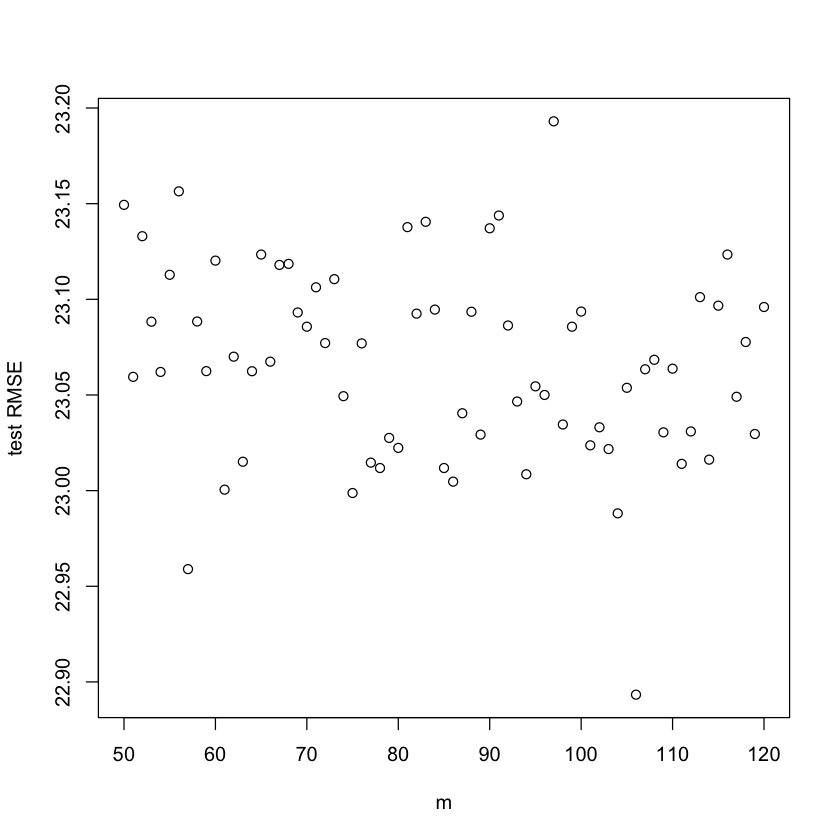

In [56]:
#Random Forest ok
set.seed(5)
random_forest <- function(m,data.train,data.test) {
    rf <- randomForest(VALENCE.PLEASANTNESS ~ ., data = data.train, mtry = m) #ntree = 500 by default
    pred <- predict(rf, data.test[,-which(names(data.train) %in% c("VALENCE.PLEASANTNESS"))])
    MSE = mean((pred - data.test$VALENCE.PLEASANTNESS)^2)
    sqrt(MSE)
}

RMSE.test <- sapply(50:120, random_forest, data.train, data.test)
#I choose m between 50 and 120 because sqrt(p) = 70 = typical choice for random forest
plot(50:120,RMSE.test,xlab='m',ylab='test RMSE')
n <- which.min(RMSE.test) + 49 #Change the 49 if we change the intervall of m 50:120
print(paste0('m that give the min test RMSE is :', n)) 
print(paste0('test RMSE min :', RMSE.test[which.min(RMSE.test)]))

rf <- randomForest(VALENCE.PLEASANTNESS ~ ., data = data.train, mtry = n+49) #Change the 49 if we change the intervall of m 50:120
pred.train <- predict(rf, data.train.x)
RMSE.train <- sqrt(mean((pred.train-data.train.y)^2))
print(paste0('train RMSE min :', RMSE.train))

In [8]:
#Boosting à relancer, peut etre changer avec les data.test.x.matrix

data.test.x<- as.matrix((model.matrix(~.-1, data.test.x)))
data.train.x <- as.matrix((model.matrix(~.-1, data.train.x)))

set.seed(3)
pows <- seq(-3.5, -0.2, by = 0.1)
lambdas <- 10^pows
train.err <- rep(NA, length(lambdas))
test.err <- rep(NA, length(lambdas))
for (i in 1:length(lambdas)) {
  boost <- xgboost(data.train.x,
                           label=data.train.y,
                           eta=lambdas[i],
                           objective="reg:squarederror",
                           max.depth=3,
                           nrounds=1000,
                           verbose = 0)
  pred.train <- predict(boost, data.train.x)
  pred.test <- predict(boost, data.test.x)
  train.err[i] <- mean((pred.train - data.train.y)^2)
  test.err[i] <- mean((pred.test - data.test.y)^2)
}

MSEmin.test <- min(test.err)
lambdamin.test <- lambdas[which.min(test.err)]
MSE.train <- train.err[which.min(test.err)]
MSEmin.train <- min(train.err)
lambdamin.train <- lambdas[which.min(train.err)]

print(paste0('test RMSE : ', sqrt(MSEmin.test)))
print(paste0('lambda min test :', lambdamin.test))
print(paste0('train RMSE with the lambda min test : ', sqrt(MSE.train)))
print(paste0('train min RMSE : ', sqrt(MSEmin.train)))
print(paste0('lambda min train : ', lambdamin.train))

[1] "test RMSE : 22.4260386806041"
[1] "lambda min test :0.00316227766016838"
[1] "train RMSE with the lambda min test : 14.3740302778053"
[1] "train min RMSE : 3.30660293636581"
[1] "lambda min test : 0.398107170553497"


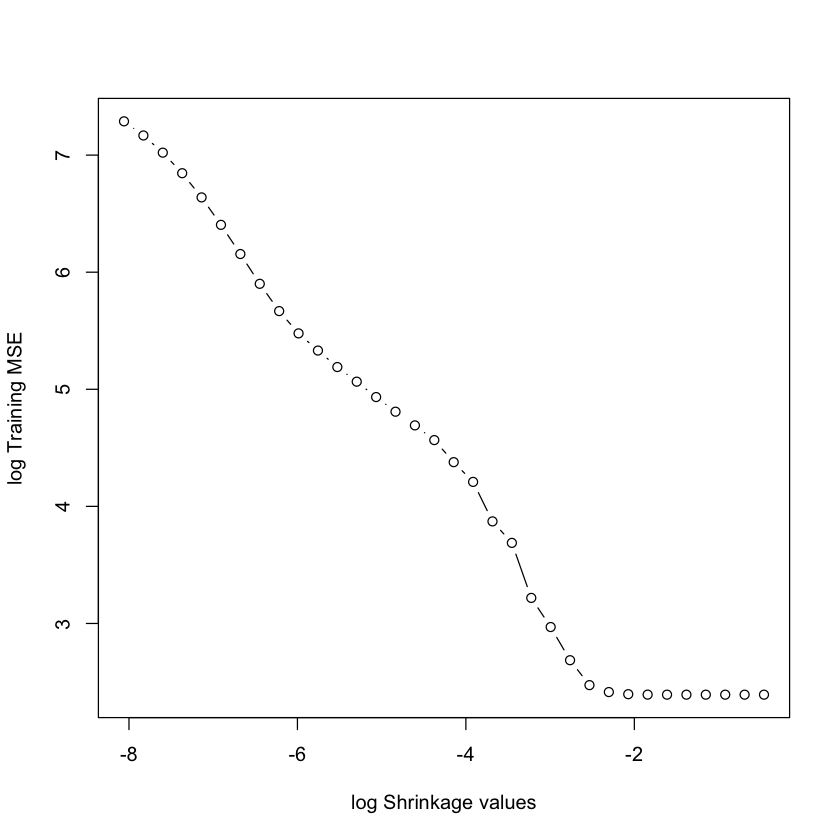

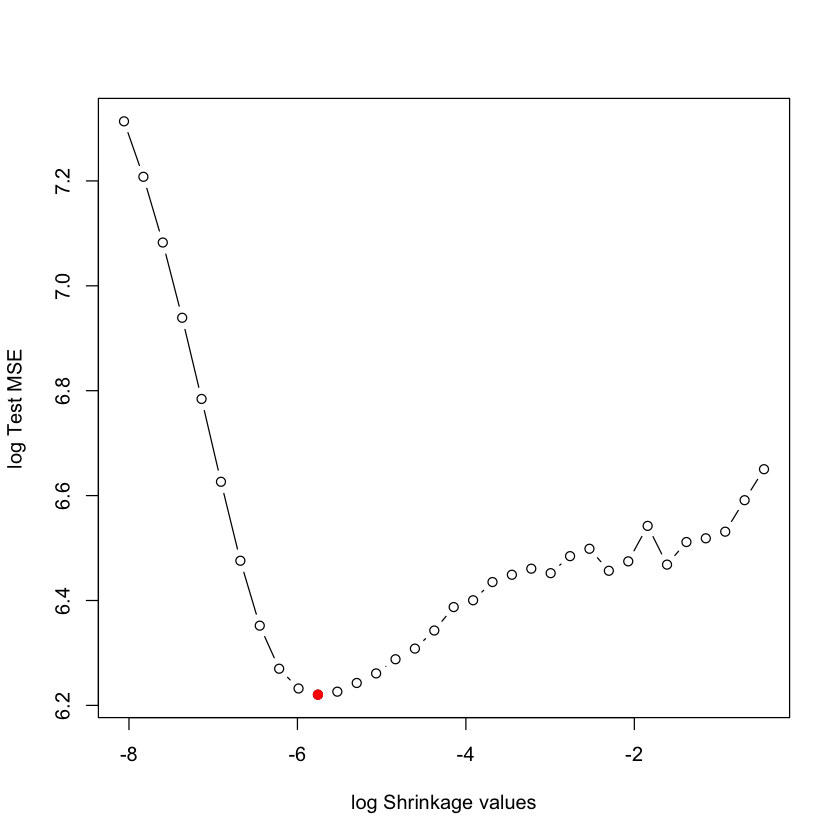

In [9]:
plot(log(lambdas), log(train.err), type="b", xlab="log Shrinkage values", ylab="log Training MSE")
plot(log(lambdas), log(test.err), type="b", xlab="log Shrinkage values", ylab="log Test MSE")
points(log(lambdas[which.min(test.err)]), log(min(test.err)), col="red", pch=19)

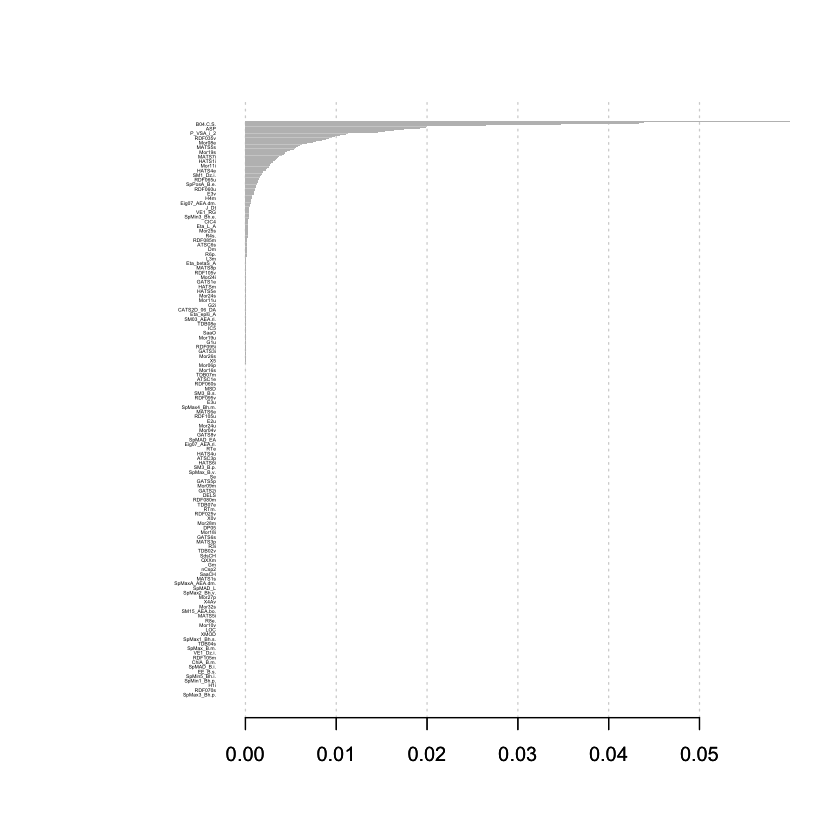

In [10]:
importance_matrix <- xgb.importance(model=boost)
xgb.plot.importance(importance_matrix=importance_matrix)

In [11]:
#Boosting with cv -> peut etre mettre toute les data dedans pas seulement train
set.seed(1)
boost.cv <- xgb.cv(params = list(eta=lambdamin.test, objective="reg:squarederror",max.depth=3),
                     data = data.train.x,
                     label = data.train.y,
                     nrounds = 1500,
                     nfold = 6,
                     verbose = 0)
print(boost.cv)

##### xgb.cv 6-folds
    iter train_rmse_mean train_rmse_std test_rmse_mean test_rmse_std
       1        48.98617      0.3524666       48.96600      1.790120
       2        48.85708      0.3523474       48.84425      1.789703
       3        48.72813      0.3521329       48.72223      1.789485
       4        48.59996      0.3520204       48.60144      1.789047
       5        48.47193      0.3518089       48.48039      1.788818
---                                                                 
    1496        11.89704      0.3147232       23.24164      1.151748
    1497        11.89468      0.3150516       23.24187      1.151921
    1498        11.89240      0.3153672       23.24270      1.152625
    1499        11.88996      0.3155262       23.24261      1.152408
    1500        11.88765      0.3155635       23.24293      1.152211


[1] "the best iteration is : 1012"
[1] "the best CV RMSE is : 23.0130048333333"


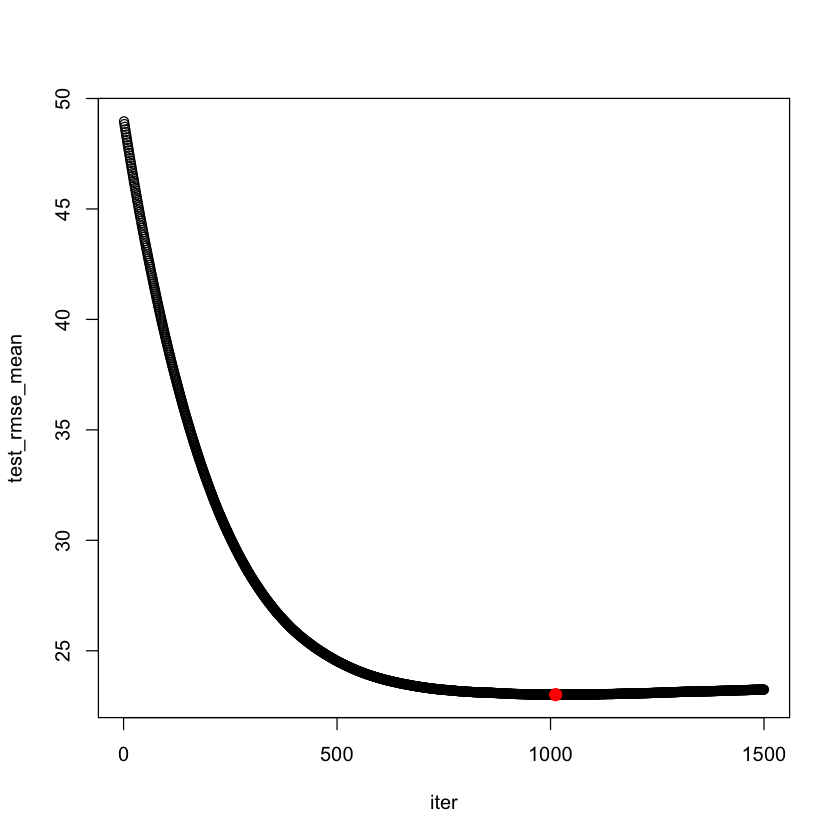

In [12]:
df <- data.frame(X = boost.cv$evaluation_log[,1], Y=boost.cv$evaluation_log[,4])
plot(df)
df_m <- as.matrix(df)
min <- which.min(df_m[,2])
print(paste0('the best iteration is : ',df_m[,1][min]))
print(paste0('the best CV RMSE is : ',df_m[,2][min]))
points(df_m[,1][min],df_m[,2][min], col = "red", cex = 2, pch = 20)

In [13]:
best.boost <- xgboost(data.train.x,
                           label=data.train.y,
                           eta=lambdamin.test,
                           objective="reg:squarederror",
                           max.depth=3,
                           nrounds=df_m[,1][min],
                           verbose = 0)

pred.train <- predict(best.boost, data.train.x)
pred.test <- predict(best.boost, data.test.x)
RMSE.train <- sqrt(mean((pred.train - data.train.y)^2))
RMSE.test <- sqrt(mean((pred.test - data.test.y)^2))
print(paste0('the best train RMSE is : ',RMSE.train))
print(paste0('the best test RMSE is : ',RMSE.test))

[1] "the best train RMSE is : 14.3238345862892"
[1] "the best test RMSE is : 22.422066638086"


In [55]:
#Submission Boosting
data_training <- read.csv(file.path("..", "data", "training_data.csv"))
data_training$Intensity<-as.numeric(as.factor(data_training$Intensity))
data_training <- data_training[,-which(names(data_training) %in% c("VALENCE.PLEASANTNESS"))]
data_training <-data_training[,-which(names(data_training) %in% c("SWEETORSOUR"))]

data_test <- read.csv(file.path("..", "data", "test_data.csv"))
data_test <- data_test[,-1]
data_test$Intensity<-as.numeric(as.factor(data_test$Intensity)) 
data_test <-data_test[ ,( which(apply(data_training, 2, var) != 0))]#remove the same predictors   
data_test_matrix <- as.matrix((model.matrix(~.-1, data_test)))
#dim(data_test)
#dim(data.train.x)
pred_test <- predict(best.boost,data_test_matrix)
#pred_test
data_sub <- read.csv(file.path("..", "data", "sampleSubmission.csv"))
data_sub <- data_sub[-69,]
data_sub$VALENCE.PLEASANTNESS <- pred_test
#data_sub
write.csv(data_sub,file="Sub1.csv", row.names = FALSE)

[1]   68 3028

[1]  354 3028

[1] 25.80420 49.40403 38.49823 50.59322 36.98544 52.95176 31.60531 44.30209
 [9] 42.76369 45.97680 17.95554 56.85107 46.52300 47.59798 31.00368 46.38383
[17] 33.69467 34.60616 36.42225 45.67200 57.94426 42.56377 40.14616 44.25731
[25] 34.69611 44.58356 55.79344 56.40598 51.51726 26.75031 50.58969 40.98795
[33] 18.18669 41.87286 51.12593 44.89864 48.13006 39.50040 48.08022 28.17489
[41] 48.12181 40.65615 47.58392 47.69035 48.95547 40.95615 37.79375 51.59121
[49] 28.46916 29.65006 38.45066 41.91650 62.32721 38.38544 53.74103 51.94398
[57] 40.09200 44.48311 35.00962 51.37107 33.50298 34.61399 45.53457 26.53922
[65] 46.20265 49.50725 38.22484 50.08969

Id,VALENCE.PLEASANTNESS
1,25.80420
2,49.40403
3,38.49823
4,50.59322
5,36.98544
6,52.95176
7,31.60531
8,44.30209
9,42.76369
10,45.97680
